In [1]:
# Cell 1: Load Both Models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

print("INTEGRATED RISK-COST MODEL")
print("="*70)

# Load models
readmit_model = joblib.load(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\models\readmission_model_final.pkl')
cost_model = joblib.load(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\models\cost_prediction_model.pkl')

# Load data
X = pd.read_csv(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\data\processed\features.csv')
y_readmit = pd.read_csv(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\data\processed\target.csv')['early_readmit']
costs = pd.read_csv(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\data\processed\costs.csv')['cost']

print("✓ Models and data loaded!")
print(f"  Records: {len(X):,}")

INTEGRATED RISK-COST MODEL
✓ Models and data loaded!
  Records: 101,766


In [2]:
# Cell 2: Generate Predictions for ALL Patients
print("GENERATING INTEGRATED PREDICTIONS")
print("="*70)

# Predict readmission risk (probability)
readmit_risk = readmit_model.predict_proba(X)[:, 1]  # Probability of readmission

# Predict expected cost
predicted_cost = cost_model.predict(X)

# Create integrated dataframe
integrated_df = pd.DataFrame({
    'readmit_risk': readmit_risk,
    'predicted_cost': predicted_cost,
    'actual_readmit': y_readmit,
    'actual_cost': costs
})

print("✓ Predictions generated!")
print(f"\nReadmission Risk Statistics:")
print(f"  Mean: {readmit_risk.mean():.2%}")
print(f"  Min: {readmit_risk.min():.2%}")
print(f"  Max: {readmit_risk.max():.2%}")

print(f"\nPredicted Cost Statistics:")
print(f"  Mean: ${predicted_cost.mean():,.2f}")
print(f"  Min: ${predicted_cost.min():,.2f}")
print(f"  Max: ${predicted_cost.max():,.2f}")

GENERATING INTEGRATED PREDICTIONS
✓ Predictions generated!

Readmission Risk Statistics:
  Mean: 44.32%
  Min: 1.66%
  Max: 96.33%

Predicted Cost Statistics:
  Mean: $40,262.86
  Min: $10,957.11
  Max: $129,680.46


In [3]:
# Cell 3: Calculate Expected Cost (Key Metric!)
print("CALCULATING EXPECTED COST")
print("="*70)

# Expected cost = Base cost + (Readmission Risk × Additional Readmission Cost)
# Assumption: Readmission adds 30% more cost on average
readmission_cost_multiplier = 0.30

integrated_df['expected_total_cost'] = (
    integrated_df['predicted_cost'] * 
    (1 + integrated_df['readmit_risk'] * readmission_cost_multiplier)
)

print("✓ Expected costs calculated!")
print(f"\nExpected Total Cost Statistics:")
print(f"  Mean: ${integrated_df['expected_total_cost'].mean():,.2f}")
print(f"  Min: ${integrated_df['expected_total_cost'].min():,.2f}")
print(f"  Max: ${integrated_df['expected_total_cost'].max():,.2f}")

# Show examples
print("\n📊 Sample Patients:")
sample = integrated_df.sample(5, random_state=42)
print(sample[['readmit_risk', 'predicted_cost', 'expected_total_cost']].to_string())

CALCULATING EXPECTED COST
✓ Expected costs calculated!

Expected Total Cost Statistics:
  Mean: $45,746.76
  Min: $11,072.64
  Max: $158,073.57

📊 Sample Patients:
       readmit_risk  predicted_cost  expected_total_cost
35956      0.282134    63221.458130         68572.543875
60927      0.155425    20245.075474         21189.055118
79920      0.486064    35310.090771         40458.980825
50078      0.347083    48994.015056         54095.505416
44080      0.568382    19734.092086         23099.045589


CREATING RISK-COST MATRIX
✓ Patient categorization complete!

📊 Risk-Cost Matrix (Patient Count):
cost_category  High Cost  Low Cost  Medium Cost
risk_category                                  
High Risk          21518     25303        44927
Low Risk             503       517          562
Medium Risk          876      5053         2507


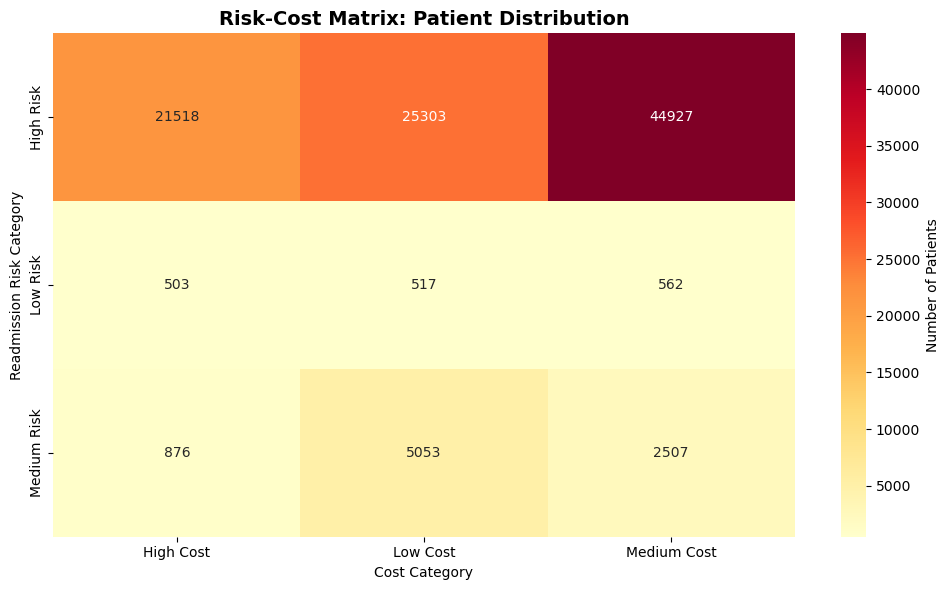

In [4]:
# Cell 4: Risk-Cost Matrix - Patient Categorization
print("CREATING RISK-COST MATRIX")
print("="*70)

# Define risk and cost categories
# Risk: Low (<10%), Medium (10-25%), High (>25%)
# Cost: Low (<$30k), Medium ($30k-$50k), High (>$50k)

def categorize_risk(risk):
    if risk < 0.10:
        return 'Low Risk'
    elif risk < 0.25:
        return 'Medium Risk'
    else:
        return 'High Risk'

def categorize_cost(cost):
    if cost < 30000:
        return 'Low Cost'
    elif cost < 50000:
        return 'Medium Cost'
    else:
        return 'High Cost'

integrated_df['risk_category'] = integrated_df['readmit_risk'].apply(categorize_risk)
integrated_df['cost_category'] = integrated_df['predicted_cost'].apply(categorize_cost)

# Priority scoring: Higher score = Higher priority for intervention
# Priority = Risk Score (0-100) + Cost Score (0-100)
integrated_df['risk_score'] = (integrated_df['readmit_risk'] * 100).round(1)
integrated_df['cost_score'] = ((integrated_df['predicted_cost'] / integrated_df['predicted_cost'].max()) * 100).round(1)
integrated_df['priority_score'] = integrated_df['risk_score'] + integrated_df['cost_score']

print("✓ Patient categorization complete!")

# Count by category
risk_cost_matrix = pd.crosstab(integrated_df['risk_category'], 
                                integrated_df['cost_category'])
print("\n📊 Risk-Cost Matrix (Patient Count):")
print(risk_cost_matrix)

# Visualize matrix
plt.figure(figsize=(10, 6))
sns.heatmap(risk_cost_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Number of Patients'})
plt.title('Risk-Cost Matrix: Patient Distribution', fontweight='bold', fontsize=14)
plt.ylabel('Readmission Risk Category')
plt.xlabel('Cost Category')
plt.tight_layout()
plt.savefig(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\results\risk_cost_matrix.png', 
            dpi=150, bbox_inches='tight')
plt.show()

IDENTIFYING HIGH-PRIORITY PATIENTS
Total patients: 101,766
High-priority patients (top 10%): 10,246

High-Priority Patient Characteristics:
  Average readmission risk: 63.38%
  Average predicted cost: $66,148.90
  Average expected total cost: $78,166.16

Overall Population:
  Average readmission risk: 44.32%
  Average predicted cost: $40,262.86
  Average expected total cost: $45,746.76


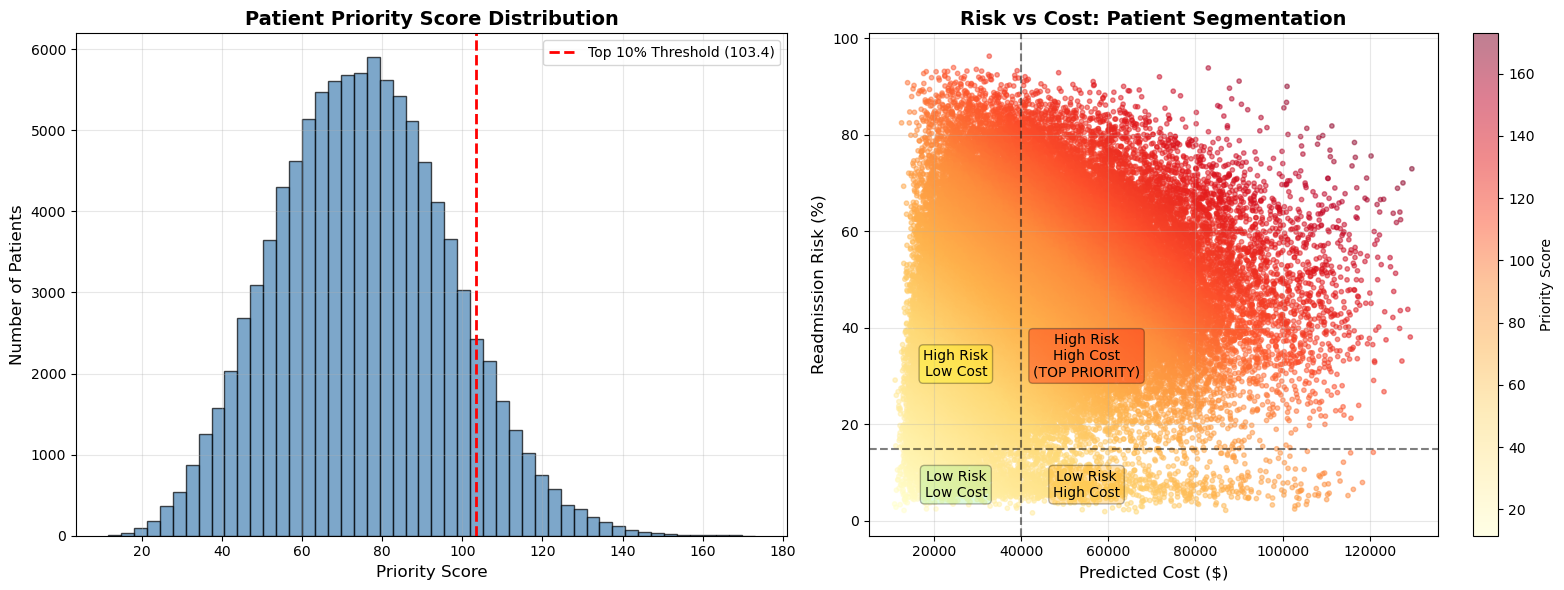

In [5]:
# Cell 5: Identify High-Priority Patients
print("IDENTIFYING HIGH-PRIORITY PATIENTS")
print("="*70)

# Top 10% highest priority patients
top_10_pct_threshold = integrated_df['priority_score'].quantile(0.90)
high_priority_patients = integrated_df[integrated_df['priority_score'] >= top_10_pct_threshold]

print(f"Total patients: {len(integrated_df):,}")
print(f"High-priority patients (top 10%): {len(high_priority_patients):,}")
print(f"\nHigh-Priority Patient Characteristics:")
print(f"  Average readmission risk: {high_priority_patients['readmit_risk'].mean():.2%}")
print(f"  Average predicted cost: ${high_priority_patients['predicted_cost'].mean():,.2f}")
print(f"  Average expected total cost: ${high_priority_patients['expected_total_cost'].mean():,.2f}")

# Compare to overall population
print(f"\nOverall Population:")
print(f"  Average readmission risk: {integrated_df['readmit_risk'].mean():.2%}")
print(f"  Average predicted cost: ${integrated_df['predicted_cost'].mean():,.2f}")
print(f"  Average expected total cost: ${integrated_df['expected_total_cost'].mean():,.2f}")

# Visualize priority distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Priority score distribution
axes[0].hist(integrated_df['priority_score'], bins=50, color='steelblue', 
             edgecolor='black', alpha=0.7)
axes[0].axvline(top_10_pct_threshold, color='red', linestyle='--', linewidth=2, 
                label=f'Top 10% Threshold ({top_10_pct_threshold:.1f})')
axes[0].set_xlabel('Priority Score', fontsize=12)
axes[0].set_ylabel('Number of Patients', fontsize=12)
axes[0].set_title('Patient Priority Score Distribution', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Scatter: Risk vs Cost with priority coloring
scatter = axes[1].scatter(integrated_df['predicted_cost'], 
                          integrated_df['readmit_risk'] * 100,
                          c=integrated_df['priority_score'], 
                          cmap='YlOrRd', alpha=0.5, s=10)
axes[1].set_xlabel('Predicted Cost ($)', fontsize=12)
axes[1].set_ylabel('Readmission Risk (%)', fontsize=12)
axes[1].set_title('Risk vs Cost: Patient Segmentation', fontweight='bold', fontsize=14)
axes[1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='Priority Score')

# Add quadrant lines
axes[1].axhline(y=15, color='black', linestyle='--', alpha=0.5)
axes[1].axvline(x=40000, color='black', linestyle='--', alpha=0.5)

# Add quadrant labels
axes[1].text(25000, 30, 'High Risk\nLow Cost', ha='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
axes[1].text(55000, 30, 'High Risk\nHigh Cost\n(TOP PRIORITY)', ha='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
axes[1].text(25000, 5, 'Low Risk\nLow Cost', ha='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
axes[1].text(55000, 5, 'Low Risk\nHigh Cost', ha='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='orange', alpha=0.3))

plt.tight_layout()
plt.savefig(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\results\priority_analysis.png', 
            dpi=150, bbox_inches='tight')
plt.show()

BUSINESS VALUE ANALYSIS

💰 INTERVENTION PROGRAM ROI:
Target Population: 10,246 high-priority patients

Expected Outcomes:
  Baseline readmissions (without intervention): 6,494
  Prevented readmissions (30% reduction): 1,948

Financial Impact:
  Cost savings from prevented readmissions: $29,224,804.33
  Total intervention cost: $5,123,000.00
  NET SAVINGS: $24,101,804.33
  ROI: 470.5%

💡 For every $1 spent on intervention, save $5.70


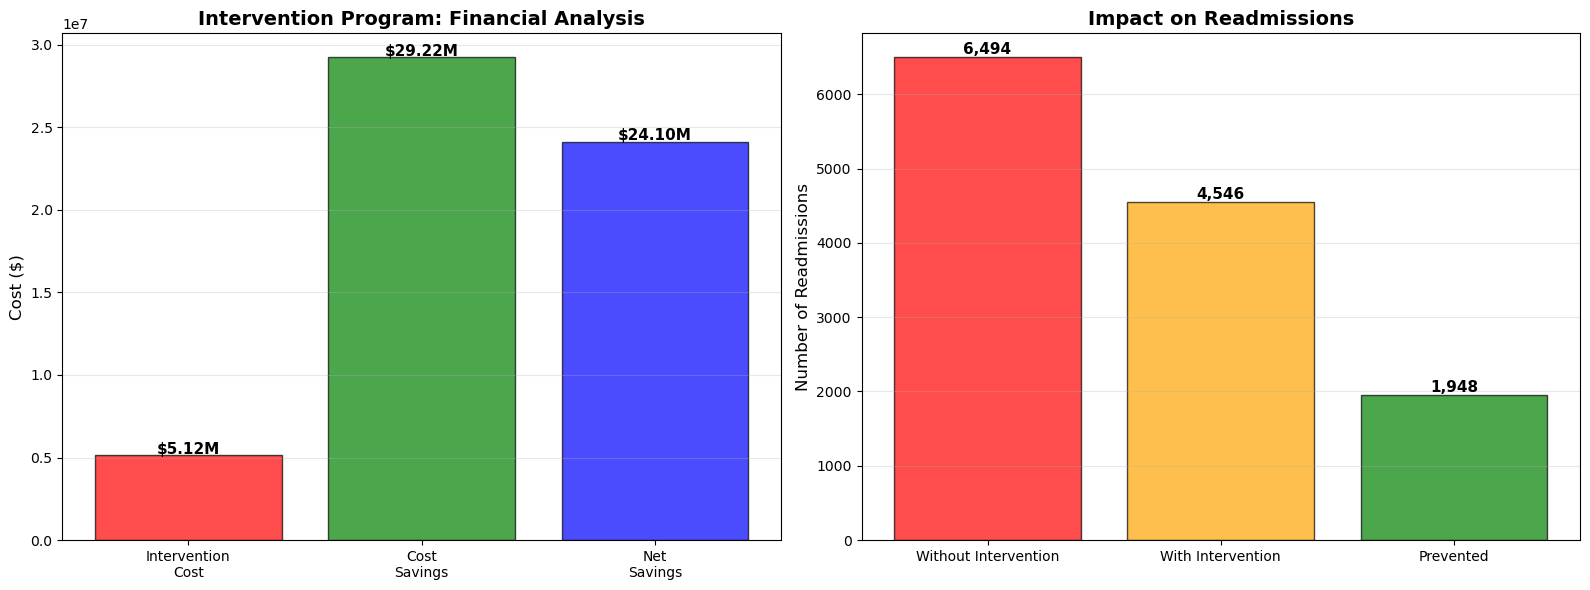

In [6]:
# Cell 6: Business Value & ROI Analysis
print("BUSINESS VALUE ANALYSIS")
print("="*70)

# Assumptions for intervention program
intervention_cost_per_patient = 500  # Cost to provide care coordination/follow-up
intervention_effectiveness = 0.30  # 30% reduction in readmissions
cost_per_readmission = 15000  # Average cost of a readmission

# Calculate potential savings from intervening on high-priority patients
high_priority_count = len(high_priority_patients)
baseline_readmissions = high_priority_count * high_priority_patients['readmit_risk'].mean()
prevented_readmissions = baseline_readmissions * intervention_effectiveness
cost_savings = prevented_readmissions * cost_per_readmission
intervention_total_cost = high_priority_count * intervention_cost_per_patient
net_savings = cost_savings - intervention_total_cost
roi = (net_savings / intervention_total_cost) * 100

print(f"\n💰 INTERVENTION PROGRAM ROI:")
print("="*70)
print(f"Target Population: {high_priority_count:,} high-priority patients")
print(f"\nExpected Outcomes:")
print(f"  Baseline readmissions (without intervention): {baseline_readmissions:,.0f}")
print(f"  Prevented readmissions (30% reduction): {prevented_readmissions:,.0f}")
print(f"\nFinancial Impact:")
print(f"  Cost savings from prevented readmissions: ${cost_savings:,.2f}")
print(f"  Total intervention cost: ${intervention_total_cost:,.2f}")
print(f"  NET SAVINGS: ${net_savings:,.2f}")
print(f"  ROI: {roi:.1f}%")

print(f"\n💡 For every $1 spent on intervention, save ${(cost_savings/intervention_total_cost):.2f}")

# Visualize ROI
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cost breakdown
categories = ['Intervention\nCost', 'Cost\nSavings', 'Net\nSavings']
values = [intervention_total_cost, cost_savings, net_savings]
colors = ['red', 'green', 'blue']

axes[0].bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Cost ($)', fontsize=12)
axes[0].set_title('Intervention Program: Financial Analysis', fontweight='bold', fontsize=14)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(values):
    axes[0].text(i, v + 100000, f'${v/1e6:.2f}M', ha='center', fontweight='bold', fontsize=11)

# Readmissions prevented
readmit_data = pd.DataFrame({
    'Scenario': ['Without Intervention', 'With Intervention', 'Prevented'],
    'Readmissions': [baseline_readmissions, baseline_readmissions - prevented_readmissions, prevented_readmissions]
})

bars = axes[1].bar(readmit_data['Scenario'], readmit_data['Readmissions'], 
                   color=['red', 'orange', 'green'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Number of Readmissions', fontsize=12)
axes[1].set_title('Impact on Readmissions', fontweight='bold', fontsize=14)
axes[1].grid(axis='y', alpha=0.3)

for bar, val in zip(bars, readmit_data['Readmissions']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                 f'{int(val):,}', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\results\roi_analysis.png', 
            dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# Cell 7: Save Integrated Predictions
print("SAVING INTEGRATED MODEL OUTPUTS")
print("="*70)

# Save full predictions
integrated_df.to_csv(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\data\processed\integrated_predictions.csv', 
                     index=False)

# Save high-priority patient list
high_priority_patients.to_csv(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\data\processed\high_priority_patients.csv', 
                               index=False)

print("✓ Integrated predictions saved!")
print(f"  Full predictions: integrated_predictions.csv ({len(integrated_df):,} patients)")
print(f"  High-priority list: high_priority_patients.csv ({len(high_priority_patients):,} patients)")

print("\n" + "="*70)
print("🎉 INTEGRATED RISK-COST MODEL COMPLETE! 🎉")
print("="*70)

print("\n📊 SUMMARY:")
print(f"  Readmission Model AUC: 0.6857")
print(f"  Cost Prediction R²: 0.8982")
print(f"  High-Priority Patients: {len(high_priority_patients):,} (10%)")
print(f"  Potential Annual Savings: ${net_savings:,.2f}")
print(f"  ROI: {roi:.1f}%")

SAVING INTEGRATED MODEL OUTPUTS
✓ Integrated predictions saved!
  Full predictions: integrated_predictions.csv (101,766 patients)
  High-priority list: high_priority_patients.csv (10,246 patients)

🎉 INTEGRATED RISK-COST MODEL COMPLETE! 🎉

📊 SUMMARY:
  Readmission Model AUC: 0.6857
  Cost Prediction R²: 0.8982
  High-Priority Patients: 10,246 (10%)
  Potential Annual Savings: $24,101,804.33
  ROI: 470.5%
